# Data Exploration on Patient Discharge dataset 

- Data: National Discharge Dataset on substance abuse patients from 2007 to 2013 including 64 variables that contain demographic, patient, and substance-related variables 
- Objective: Exploratory Data Analysis on 2013 Texas patient discharge dataset to understand the dataset better
- Assumption: Use the most recent dataset available (2013). Each yearly dateset has an approximately same number of rows and attributes. 
- Outcome: We want to predict LOS (Length of Stay) and REASON (success of patient treatment) with the highest accuracy 
- Note: Codebook for all the variables at the end of this notebook 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import math
import time

from sklearn.model_selection import (train_test_split,KFold)
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from xgboost import XGBClassifier

/Users/chloekwon/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [1]:
import pandas as pd 
data_2013 = pd.read_csv("teds_d_2013.csv")

In [2]:
data_2013.head()

,CASEID,DISYR,AGE,GENDER,RACE,ETHNIC,MARSTAT,EDUC,EMPLOY,DETNLF,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,ALCDRUG,DSMCRIT,PSYPROB,HLTHINS,PRIMPAY
0,20130000001,2013,5,1,5,5,1,-9,1,-9,...,0,0,0,0,0,3,7,2,4,-9
1,20130000002,2013,6,1,4,5,1,-9,3,-9,...,0,0,0,0,1,3,7,2,4,-9
2,20130000003,2013,6,1,5,5,1,-9,4,5,...,0,0,0,0,1,3,8,1,3,-9
3,20130000004,2013,9,2,4,5,1,3,4,1,...,0,0,0,0,0,3,7,1,3,-9
4,20130000005,2013,7,1,5,5,1,-9,3,-9,...,0,0,0,0,0,2,5,2,4,-9


In [3]:
data_2013.shape

(1601220, 64)

Confirm that there are no missing data within 2013 dataset 

In [4]:
data_2013.isnull().values.any() 

False

We'll zoom in and look at only Texas data 
- Business application of this dataset could be better understood in Texas 
- If we were to take the analysis further with actionable insights, we could possibly approach Dell Medical School or Baylor Medical School 

In [5]:
texas_data_2013 = data_2013.loc[data_2013['STFIPS'] == 48]
texas_data_2013.shape

(39695, 64)

In [6]:
texas_data_2013.columns

Index([u'CASEID', u'DISYR', u'AGE', u'GENDER', u'RACE', u'ETHNIC', u'MARSTAT',
       u'EDUC', u'EMPLOY', u'DETNLF', u'PREG', u'VET', u'LIVARAG', u'PRIMINC',
       u'ARRESTS', u'STFIPS', u'CBSA', u'REGION', u'DIVISION', u'SERVSETD',
       u'METHUSE', u'DAYWAIT', u'REASON', u'LOS', u'PSOURCE', u'DETCRIM',
       u'NOPRIOR', u'SUB1', u'ROUTE1', u'FREQ1', u'FRSTUSE1', u'SUB2',
       u'ROUTE2', u'FREQ2', u'FRSTUSE2', u'SUB3', u'ROUTE3', u'FREQ3',
       u'FRSTUSE3', u'NUMSUBS', u'IDU', u'ALCFLG', u'COKEFLG', u'MARFLG',
       u'HERFLG', u'METHFLG', u'OPSYNFLG', u'PCPFLG', u'HALLFLG', u'MTHAMFLG',
       u'AMPHFLG', u'STIMFLG', u'BENZFLG', u'TRNQFLG', u'BARBFLG', u'SEDHPFLG',
       u'INHFLG', u'OTCFLG', u'OTHERFLG', u'ALCDRUG', u'DSMCRIT', u'PSYPROB',
       u'HLTHINS', u'PRIMPAY'],
      dtype='object')

In [7]:
#Binarize the reason column to have 1 as success and 0 as unsuccessful 
reason_no = texas_data_2013[texas_data_2013['REASON'] != 1] 
texas_data_2013.loc[texas_data_2013['REASON'] > 1, 'REASON'] = 0

/Users/chloekwon/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/chloekwon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Explore correlation of features to LOS (Length of Stay) and REASON (success) features

In [9]:
corr_all = texas_data_2013.corr() 
corr_LOG = pd.DataFrame(corr_all['LOS'].drop('LOS'))
corr_LOG.sort_values(by='LOS', ascending = False)[:10]

,LOS
SERVSETD,0.642891
PSOURCE,0.428341
DETCRIM,0.357890
MARFLG,0.229372
LIVARAG,0.152177
DETNLF,0.138717
REASON,0.109135
CBSA,0.090794
ARRESTS,0.071557
ALCDRUG,0.065087


In [10]:
corr_reason = pd.DataFrame(corr_all['REASON'].drop('REASON'))
corr_reason.sort_values(by='REASON', ascending=False)[:10]

,REASON
LOS,0.109135
METHUSE,0.073205
ALCFLG,0.061001
AGE,0.060201
EDUC,0.055522
LIVARAG,0.055475
DETCRIM,0.053287
FRSTUSE1,0.051039
PRIMPAY,0.046379
PSOURCE,0.045998


Analyzing LOS (Length of Stay)

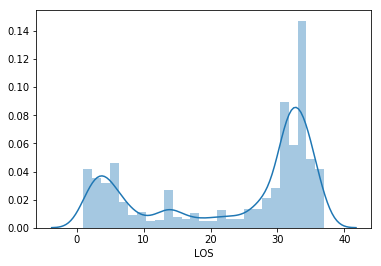

In [12]:
#Histogram 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sns.distplot(texas_data_2013['LOS']) 
#Deviates from normal distribution 
#Left Skewed, bi-modal distribution 
#Show peakness at around 34

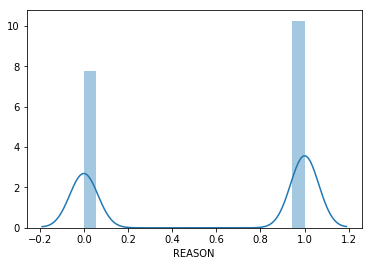

In [13]:
#Analyzing REASON 

sns.distplot(texas_data_2013['REASON'])

57% of the people have had "successful" outcome 

In [14]:
reason_1 = texas_data_2013[texas_data_2013['REASON'] == 1]
len(reason_1)*1.0 / len(texas_data_2013['REASON'])

0.5698702607381282

More frequent use of substance does not necessarily correlate to having higher length of stay

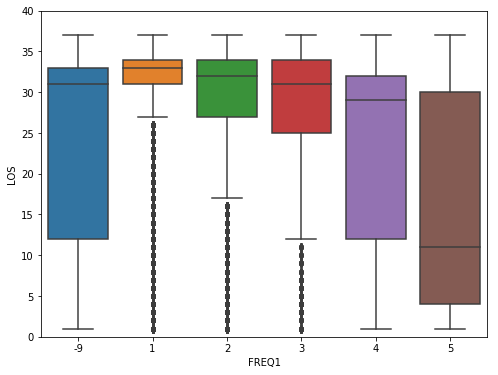

In [17]:
data = pd.concat([texas_data_2013['LOS'], texas_data_2013['FREQ1']], axis=1)
label = ["Missing", "0 Use", "1-3/month", "1-2/week", "3-6/week", "Daily"]
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='FREQ1', y="LOS", data=data)
fig.axis(ymin=0, ymax=40);

I expected having 1=homeless to have longest length of stay, but it turned out not 

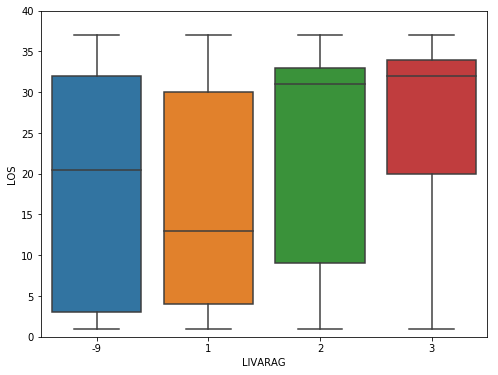

In [18]:
data_2 = pd.concat([texas_data_2013['LIVARAG'], texas_data_2013['LOS']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='LIVARAG', y="LOS", data=data_2)
fig.axis(ymin=0, ymax=40);

Number of Substance reported at admission doesn't have much effect on length of stay

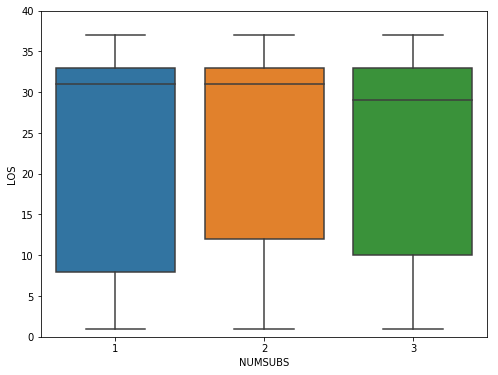

In [19]:
data_3 = pd.concat([texas_data_2013['NUMSUBS'], texas_data_2013['LOS']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='NUMSUBS', y="LOS", data=data_3)
fig.axis(ymin=0, ymax=40);

Seems to be that 12-17 stays longest but not by far 

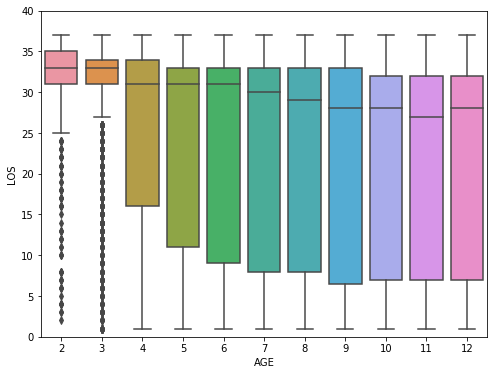

In [20]:
data_4 = pd.concat([texas_data_2013['AGE'], texas_data_2013['LOS']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='AGE', y="LOS", data=data_4)
fig.axis(ymin=0, ymax=40);

Let's dig into success outcome 
- Age doesn't seem to differ in success of outcome 

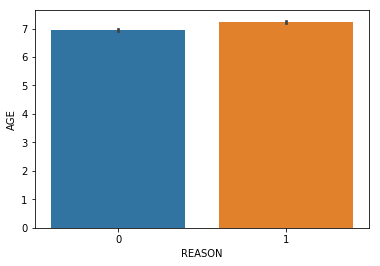

In [21]:
sns.barplot(x="REASON", y="AGE",  data=texas_data_2013);

GENDER doesn't seem to mater for success

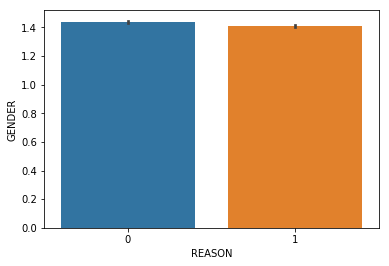

In [22]:
sns.barplot(x='REASON', y='GENDER', data=texas_data_2013)

Frequency of use matters slightly, but more frequent user had higher success (but this could be attributed to other attributes that are linked to higher success rate like age, education, etc)

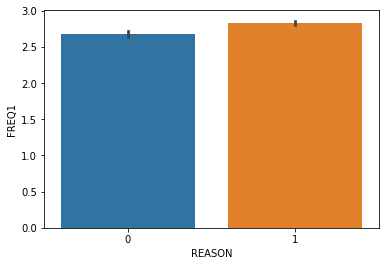

In [23]:
sns.barplot(x='REASON', y='FREQ1', data=texas_data_2013)

Include only attributes that will be helpful in predicting outcomes. In general, Do not include attribute that has more than 20% Unknown. 

In [24]:
field_list = ['CASEID', 'AGE', 'GENDER', 'RACE', 'EDUC', 'EMPLOY', 'LIVARAG', 'ARRESTS', 'PSYPROB', 'FREQ1','FRSTUSE1','MARSTAT','NOPRIOR','NUMSUBS','PREG','PSOURCE','LOS', 'REASON']
texas_2013 = texas_data_2013[field_list]
texas_2013[:10]

,CASEID,AGE,GENDER,RACE,EDUC,EMPLOY,LIVARAG,ARRESTS,PSYPROB,FREQ1,FRSTUSE1,MARSTAT,NOPRIOR,NUMSUBS,PREG,PSOURCE,LOS,REASON
8373,20130008375,7,1,5,-9,1,3,0,-9,2,4,3,1,3,-9,5,8,0
24884,20130024886,6,2,5,-9,3,3,0,-9,1,4,1,1,3,1,6,33,0
29795,20130029799,4,2,5,3,2,3,0,-9,1,3,1,4,3,1,1,35,1
35275,20130035279,10,1,5,3,4,3,0,-9,4,6,1,3,1,-9,6,23,0
37306,20130037310,5,2,5,3,3,2,0,-9,5,3,1,1,1,1,2,34,0
41958,20130041962,10,2,5,3,3,3,0,-9,5,10,3,1,2,2,3,35,0
53497,20130053502,10,1,-9,4,3,2,0,-9,5,5,1,5,2,-9,2,36,1
55592,20130055597,8,2,5,3,4,3,0,-9,5,7,3,5,1,2,7,35,0
58451,20130058456,5,2,21,3,3,3,0,-9,1,3,1,1,1,1,6,26,1
73220,20130073227,8,2,4,4,4,3,0,-9,5,7,1,1,2,1,1,32,1


Obviously pregnancy and gender is correlated. FREQ1 and EDUC's correlation is around 0.6, EDUC and LIVARAG is around 0.4 



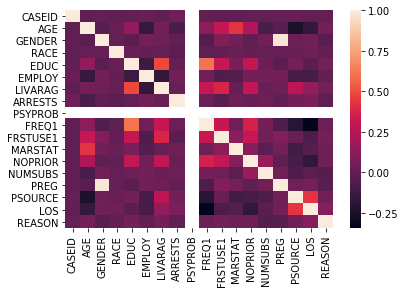

In [25]:
corr = texas_2013.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Data Preprosessing 

Impute missing values, dummy code in order to fit into models (from binned variables or categorical variables), and design our outcome variables into two outcomes (success/failure), and take samples from each year and concatenate them to decrease computational time. 

In [2]:
data07=pd.read_csv("TEDS-D-2007-DS0001-data-excel.tsv", sep='\t')
data08=pd.read_csv("TEDS-D-2008-DS0001-data-excel.tsv", sep='\t')
data09=pd.read_csv("TEDS-D-2009-DS0001-data-excel.tsv", sep='\t')
data10=pd.read_csv("TEDS-D-2010-DS0001-data-excel.tsv", sep='\t')
data11=pd.read_csv("TEDS-D-2011-DS0001-data-excel.tsv", sep='\t')
data12=pd.read_csv("TEDS-D-2012-DS0001-data-excel.csv")
sample07=data07.sample(n=10000)
sample08=data08.sample(n=10000)
sample09=data09.sample(n=10000)
sample10=data10.sample(n=10000)
sample11=data11.sample(n=10000)
sample12=data12.sample(n=10000)

In [3]:
frames=[sample07,sample08,sample09,sample10,sample11,sample12]
full_data=pd.concat(frames)
full_data[:10]

,AGE,ALCDRUG,ALCFLG,AMPHFLG,ARRESTS,BARBFLG,BENZFLG,CASEID,CBSA,COKEFLG,...,ROUTE3,SEDHPFLG,SERVSETD,STFIPS,STIMFLG,SUB1,SUB2,SUB3,TRNQFLG,VET
957203,5,3,1,0,NaN,0,0,957204,22220,0,...,-9,0,4,5,0,4,2,-9,0,2
1094234,10,2,0,0,NaN,0,0,1094235,27740,0,...,-9,0,4,47,0,7,1,1,0,2
387377,9,3,1,0,NaN,0,0,387378,19820,1,...,-9,0,7,26,0,2,3,1,0,2
850942,10,3,1,0,NaN,0,0,850943,35620,1,...,-9,0,4,36,0,3,2,1,0,2
429557,5,3,1,0,NaN,0,0,429558,40380,0,...,-9,0,4,36,0,2,7,1,0,2
1011407,4,3,1,0,NaN,0,0,1011408,47900,0,...,-9,0,7,24,0,4,2,1,0,-9
134699,8,3,1,0,NaN,0,0,134700,19820,0,...,-9,0,4,26,0,5,2,1,0,2
973056,3,3,1,0,NaN,0,0,973057,-9,0,...,-9,0,7,24,0,4,2,1,0,-9
972098,10,2,0,0,NaN,0,0,972099,26420,1,...,-9,0,4,48,0,3,1,1,0,2
1296614,8,3,1,0,NaN,0,0,1296615,38900,1,...,3,0,7,41,0,2,4,3,0,-9


In [4]:
#convert age to mean age--one less dummy
age_dict={2:13, 3:16, 4:19, 5:23, 6:27, 7:32, 8:37, 9:42, 10:47, 11:52, 12:55}
def group_age(s):
    if s in age_dict.keys():
        return age_dict[s]
full_data['AGE']=full_data['AGE'].map(group_age)

#delete CASEID column
del full_data['CASEID']

#update REASON column to just 0 or 1's
#updating reason column to just 1 and 0's 
def reason_func(s):
    if s==1:
        return 1
    else:
        return 0
    #question- should those be strings or integers?
    
##replace NANs with -9
full_data=full_data.replace(np.nan, '-9')

full_data['REASON']=full_data['REASON'].map(reason_func)
collist = full_data.columns.tolist()
collist.remove('ARRESTS')
collist.remove('DAYWAIT')
collist.remove('NOPRIOR')
collist.remove('NUMSUBS')
collist.remove('AGE')
collist.remove('LOS')
collist.remove('REASON')
cat_df = full_data[collist]

#make these numbers strings so that get dummies will work
for i in cat_df.columns:
    cat_df[i]=cat_df[i].astype(str)

/Users/chloekwon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df_with_dummies = pd.get_dummies( cat_df , prefix=cat_df.columns.tolist())

#add back the numeric columns (age, arrests, daywait, no prior, numsubs)
data=df_with_dummies
data['AGE']=full_data['AGE']
data['ARRESTS']=full_data['ARRESTS'].astype(int)
data['DAYWAIT']=full_data['DAYWAIT']
data['NOPRIOR']=full_data['NOPRIOR']
data['NUMSUBS']=full_data['NUMSUBS']
data['LOS']=full_data['LOS']
data['REASON']=full_data['REASON']

data['ARRESTS']=data['ARRESTS'].replace(-9,0)
data['DAYWAIT']=data['DAYWAIT'].replace(-9,0)
data['NOPRIOR']=data['NOPRIOR'].replace(-9,0)

In [35]:
data.head()

,ALCDRUG_0,ALCDRUG_1,ALCDRUG_2,ALCDRUG_3,ALCFLG_0,ALCFLG_1,AMPHFLG_0,AMPHFLG_1,BARBFLG_0,BARBFLG_1,...,VET_-9,VET_1,VET_2,AGE,ARRESTS,DAYWAIT,NOPRIOR,NUMSUBS,LOS,REASON
1161526,0,1,0,0,0,1,1,0,1,0,...,0,0,1,27,0,30,0,1,34,1
463040,0,0,1,0,1,0,1,0,1,0,...,0,0,1,19,0,0,1,1,14,1
1331156,0,1,0,0,0,1,1,0,1,0,...,0,0,1,47,0,0,0,1,33,1
1484766,0,0,0,1,0,1,1,0,1,0,...,0,1,0,55,0,0,3,2,3,1
1320203,0,1,0,0,0,1,1,0,1,0,...,0,0,1,19,0,0,1,1,33,0


# Feature Importance/Selection 

Since we have 64 variables (and more due to dummy coding - more on this later), we want to see if all or any variables are important in predicting our dependent variables (LOS and REASON) using various methods 

Using RandomForestRegressor to see if we can narrow down the attributes based on their feature importances 
- SERVSTED (Service setting at discharge) seemed most important in feature (with SERVSETD_2 importance at 0.3) but since the dummy coded SERVSTED scored pretty low as well as other variables, we should keep them to observe

In [34]:
from sklearn.ensemble import RandomForestRegressor 


y_all = data['LOS'] 
X_all = data.drop('LOS', axis = 1)
names = X_all.columns 

rf = RandomForestRegressor() 
rf.fit(X_all, y_all)

# sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
df = pd.DataFrame(names, map(lambda x: round(x,4), rf.feature_importances_))

In [71]:
df = df.reset_index()
df.columns = ['Feature Importance', 'Feature']

In [72]:
df.sort_values(by='Feature Importance', ascending=False)[:10]

,Feature Importance,Feature
762,0.3275,SERVSETD_2
761,0.1102,SERVSETD_1
764,0.0353,SERVSETD_4
890,0.0324,REASON
796,0.0197,STFIPS_37
885,0.0155,AGE
781,0.0153,STFIPS_21
768,0.0132,SERVSETD_8
888,0.0099,NOPRIOR
887,0.0078,DAYWAIT


Using ExtraTreesClassifier to see if we get any other outcome/illuminate on whether variables are actually important 
- They all have really low feature importance so we'll keep all the features for now 

In [73]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_all, y_all)
df_3 = pd.DataFrame(X_all.columns, model.feature_importances_)
df_4 = df_3.reset_index()
df_4.columns = ['Feature Importance', 'Feature']
df_4.sort_values('Feature Importance', ascending=False)[:10]

,Feature Importance,Feature
885,0.021288,AGE
888,0.015437,NOPRIOR
890,0.013428,REASON
328,0.012517,EDUC_3
367,0.011354,FRSTUSE1_3
767,0.010615,SERVSETD_7
327,0.009988,EDUC_2
762,0.009760,SERVSETD_2
734,0.009618,RACE_5
366,0.009374,FRSTUSE1_2


Using PCA to see if there's any benefit to shrinking the 600+ variables in increasing accuracy 

In [81]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X_all)
pca=PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

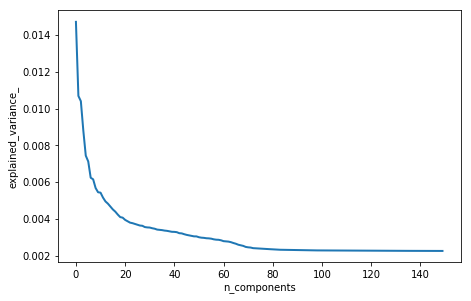

In [82]:
plt.figure(1, figsize=(8, 5))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_[:150], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [83]:
#Split dataset into train and test (here we are using LOS as our predicting variable)
X_train_scaled, X_test_scaled, y_train_los, y_test_los = train_test_split(X_scaled,y_all,test_size = 0.33, random_state=42)

#can use X_t_train and X_t_test to use models on PCA 
pca = PCA(n_components=80)
pca.fit(X_train_scaled)
X_t_train = pca.transform(X_train_scaled)
X_t_test = pca.transform(X_test_scaled)

After playing around for a bit, PCA cuts down running time of models significantly, yet does not contribute to increase in accuracy. Therefore, we'll continue to model without running PCA. 

# Modeling - REASON

Predict LOS and REASON using various different modeling packages 

In [61]:
from sklearn.model_selection import train_test_split

X=data[data.columns[data.columns!='LOS']]
y_los=data['LOS']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X,y_los,test_size = 0.33, random_state=42)

In [71]:
X=data[data.columns[data.columns!='REASON']]
y_r=data['REASON']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X,y_r,test_size = 0.33, random_state=42)

### Logistic Regression

In [41]:
logreg = linear_model.LogisticRegression(penalty='l2',C=1e5)
logreg.fit(x_train_r, y_train_r)
print "Logistic Regression Accuracy: ", logreg.score(x_test_r,y_test_r)

Logistic Regression Accuracy:  0.682


### KNN

In [45]:
knn=neighbors.KNeighborsClassifier()
knn.fit(x_train_r, y_train_r)
print "KNN Accuracy: ", knn.score(x_test_r,y_test_r)

KNN Accuracy:  0.622666666667


### Random Forest

Random Forest did slightly better than KNN 

In [50]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(random_state=42, max_features=100, max_depth=10)
# Train the Classifier to take the training features and learn how they relate to test set 
clf.fit(x_train_r, y_train_r)
print "Random Forest Accuracy: ", clf.score(x_test_r, y_test_r)

Random Forest Accuracy:  0.676666666667


### MLP (Multlayer Perceptron)  
- Class of feedforward artificual neural network 
- Part of Sklearn.neural_network package

MLP did slightly better than Random Forest (perhaps parameters such as alpha and hidden layer sizes could be optimized by GridSearchCV) in order to boost the accuracy

In [51]:
mlp= MLPClassifier(alpha=1e-1, hidden_layer_sizes=(15,), random_state=1)
mlp.fit(x_train_r, y_train_r) 
print "MLP Accuracy: ", mlp.score(x_test_r,y_test_r)

MLP Accuracy:  0.682


### MLP Classifier with SGD solver

In [23]:
from sklearn.grid_search import GridSearchCV

nn = MLPClassifier()

param = {'hidden_layer_sizes' : [1,5,20,50], 
         'max_iter' : [5,30,100], 
         'learning_rate' : ['constant'], 
         'solver' : ['sgd'], 
         'alpha': [0.00001, 0.001, 0.01, 0.1]  
        }

gs = GridSearchCV(nn, param_grid = param)
gs.fit(x_train_r, y_train_r)

print "MLP with sgd solver Accuracy: ", gs.score(x_test, y_test_r)

/Users/chloekwon/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/chloekwon/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/chloekwon/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/chloekwon/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1

MLP with sgd solver Accuracy:  0.679333333333


### XGBoost 

In [24]:
model = XGBClassifier()
model.fit(x_train_r, y_train_r)
y_pred=model.predict(x_test_r)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test_r, predictions)
print "XGBoost Accuracy: ", accuracy

XGBoost Accuracy:  0.724


XGBoost did the best for modeling for REASON variable with 72.4% accuracy. 

# Modeling - LOS (Length of Stay) 

Linear Regression shows 60.2% accuracy 

In [67]:
from sklearn.linear_model import LinearRegression 

lr = LinearRegression()
lr.fit(x_train_l, y_train_l)
print "Linear Regression Accuracy: ", lr.score(x_test_l, y_test_l) 

Linear Regression Accuracy:  0.540018019023


In [10]:
svr_model_linear = SVR(kernel = 'linear', C = 1).fit(x_train_l, y_train_l)
svr_predictions = svr_model_linear.predict(x_test_l)

# model accuracy for X_test  
accuracy = svr_model_linear.score(x_test_l, y_test_l)

print "SVM linear Model accuracy: ", accuracy


SVM linear Model accuracy:  0.540727134602


In [11]:
from sklearn.ensemble import RandomForestRegressor 

rfr = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1).fit(x_train_l, y_train_l)
print "RandomForestRegressor Accuracy: ", rfr.score(x_test_l, y_test_l)

RandomForestRegressor Accuracy:  0.610952918062


In [70]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor(n_neighbors=80,weights='uniform',p=2)
knr.fit(x_train_l, y_train_l)
print "KNeighbors Regressor Accuracy: ", knr.score(x_test_l, y_test_l)

KNeighbors Regressor Accuracy:  0.212508416567


In [13]:
from sklearn.ensemble import GradientBoostingRegressor as gBR

gbr = gBR()
gbr.fit(x_train_l, y_train_l)
print "Gradient Boosting Regressor Accuracy: ", gbr.score(x_test_l, y_test_l)

Gradient Boosting Regressor Accuracy:  0.608180807126


Random Forest Regressor did the best to predict LOS (Length of Stay) with 61.1% accuracy. 

## Codebook ## 

- Age
- Gender
- Race 
- Ethnic 
- Marstat (Marital Status; 0 - Never married, 1 - Now married, 2 - Separated, 3 - Divorced, -9 - missing) 
- EDU (Education; 1 - 8 yrs or less, 2 - 9-11, 3 - 12, 4 - 13-15, 5 - 16 or more, -9 - missing) 
- EMPLOY (Employment status; 1 - Full time, 2 - Part time, 3 - Unemployed, 4 - Not in labor force, -9 - missing) 
- DETNLF (Not in labor force detail; 1 - Homemaker, 2 - Student, 3 - Retired, disabled, 4- Other, -9 - missing) 
- PREG (Pregnant at admission; 1 - yes, 2 - no, -9 - missing) 
- VET (Veteran status; 1 - yes, 2 - no, -9 - missing) 
- LIVARAG (LIVING ARRANGEMENT; 1 - HOMELESS, 2 - DEPENDENT LIVING, 3 - INDEPENDENT LIVING, -9 - missing) 
- PRIMINC (SOURCE OF INCOME/SUPPORT; 1 - WAGES/SALARY, 2 - PUBLIC ASSISTANCE, 3 - RETIREMENT/PENSION, DISABILITY, 20 - Other, 21 - None, -9 - missing) 
- ARRESTS (NUMBER OF ARRESTS IN 30 DAYS PRIOR TO ADMISSION; 1 - NONE, 2 - Once, 3 - 2 OR MORE TIMES, -9 - missing) 
- STFIPS (CENSUS STATE FIPS CODE - Texas : 48 (39,695) 
- CBSA (FIPS 2015 CBSA CODE - code for metro area)
- REGION (0 - US JURISDICTION/TERRITORY, 1 - NORTHEAST, 2 - MIDWEST, 3 - SOUTH, 4 - WEST) 
- DIVISION (CENSUS DIVISION) 
- SERVSETD (SERVICE SETTING AT DISCHARGE)
- METHUSE (MEDICATION-ASSISTED OPIOID THERAPY)
- DAYWAIT (DAYS WAITING TO ENTER TREATMENT) 
- REASON (REASON FOR DISCHARGE) 
- LOS (LENGTH OF STAY) 
- PSOURCE (PRINCIPAL SOURCE OF REFERRAL) 
- DETCRIM: DETAILED CRIMINAL JUSTICE REFERRAL
- NOPRIOR: NUMBER OF PRIOR TREATMENT EPISODES
- SUB1: SUBSTANCE ABUSE PROBLEM (PRIMARY)
- ROUTE1: USUAL ROUTE OF ADMINISTRATION (PRIMARY)
- FREQ1: FREQUENCY OF USE (PRIMARY)
- FRSTUSE1: AGE AT FIRST USE (PRIMARY)
- SUB2: SUBSTANCE ABUSE PROBLEM (SECONDARY)
- ROUTE2: USUAL ROUTE OF ADMINISTRATION (SECONDARY)
- ALCDRUG: SUBSTANCE ABUSE TYPE
- DSMCRIT: DSM DIAGNOSIS (shows what kind of problems) 
- PSYPROB: PSYCHIATRIC PROBLEM IN ADDITION TO ALCOHOL/DRUG PROBLEM
- HLTHINS: HEALTH INSURANCE
- PRIMPAY: EXPECTED/ACTUAL PRIMARY SOURCE OF PAYMENT